In [22]:
import os
import warnings

warnings.filterwarnings("ignore")

# Data Science libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Machine Learning libraries
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.base import clone
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
)

In [3]:
# Deep Learning libraries
import tensorflow as tf
from tensorflow import keras
from keras import layers

In [4]:
# Image processing libraries
import cv2
import gc
from PIL import Image
from glob import glob

# Object persistence libraries
import joblib

In [5]:
# Local modules
from utils import make_confusion_matrix

# Lung Cancer Detection

# Background
Lung cancer is one of the leading causes of death among Americans above the age of 35. Currently, doctors are unable to diagnose patients who develop lung cancer with accuracy, and even when patients are diagnosed with lung cancer, there are many times when the carcinoma is detected all too late. 

State-of-the-art computer vision tools have the ability to classify an assortment of objects in the real world and identify them. With the Lung and Colon Cancer Histopathological Image dataset on Kaggle, the aim of this project is to train several models (2 classical supervised learning algorithms + 2 deep CNNs) in order to predict whether a CT scan of the lungs of patients show any indicators of the development of Lung Adenocarcinomas or Lung Squamous Cell Carcinomas. 

# Dataset
## Lung and Colon Cancer Histopathological Images
- 25,000 images of 5 classes including lung and colon cancer and healthy samples
- Images of size 768 x 768 pixels in jpeg format
- HIPAA compliant
### Lung Image Dataset
- 750 original images of lung tissue
  - 250 benign lung tissue
  - 250 lung adenocarcinomas
  - 250 lung squamous cell carcinomas
  - Augmented to 25,0000 images

Original Article

Borkowski AA, Bui MM, Thomas LB, Wilson CP, DeLand LA, Mastorides SM. Lung and Colon Cancer Histopathological Image Dataset (LC25000). arXiv:1912.12142v1 [eess.IV], 2019

## Data Preparation

In [6]:
lung_images = "data/lung_image_sets"
classes = os.listdir(lung_images)
classes

['lung_aca', 'lung_n', 'lung_scc']

Here, lung_n equates to CT scans of patients with normal lungs, lung_aca equates to CT scans of patients with lung adenocarcinomas, and lung_scc equates to CT scans of patients with lung squamous cell carcinomas.

In [7]:
class_map = {
    "lung_n": "Normal Lungs",
    "lung_aca": "Lung Adenocarcinomas",
    "lung_scc": "Lung Squamous Cell Carcinomas",
}

### Class Distribution

In [8]:
class_counts = {}
for c, condition in class_map.items():
    count = len(os.listdir(f"{lung_images}/{c}"))
    class_counts[condition] = count

class_counts

{'Normal Lungs': 5000,
 'Lung Adenocarcinomas': 5000,
 'Lung Squamous Cell Carcinomas': 5000}

Text(0, 0.5, '# Images')

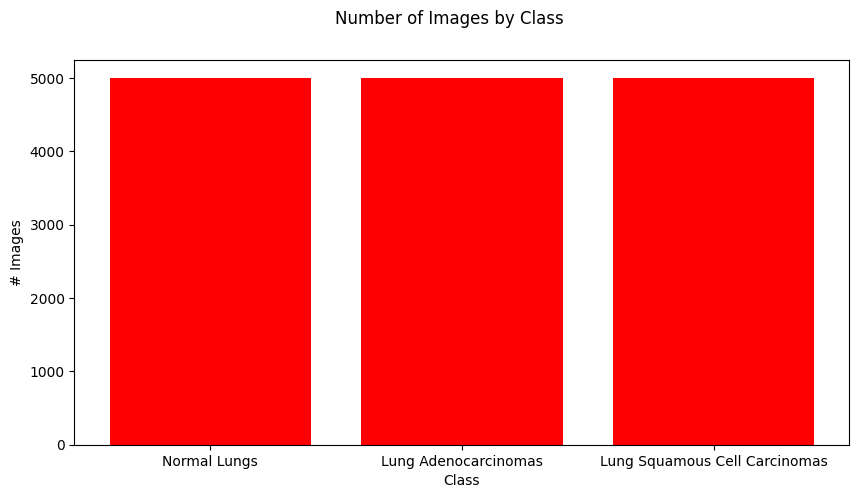

In [9]:
fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle("Number of Images by Class")
ax.bar(class_counts.keys(), class_counts.values(), color="r")
ax.set_xlabel("Class")
ax.set_ylabel("# Images")

From the barplot above, we see that our dataset is well-balanced in terms of the number of samples we have in each class which can be used to train predictive models. Each class (normal lungs, lung adenocarcinomas, lung squamous cell carcinomas) has 5,000 image samples.

### Image Samples

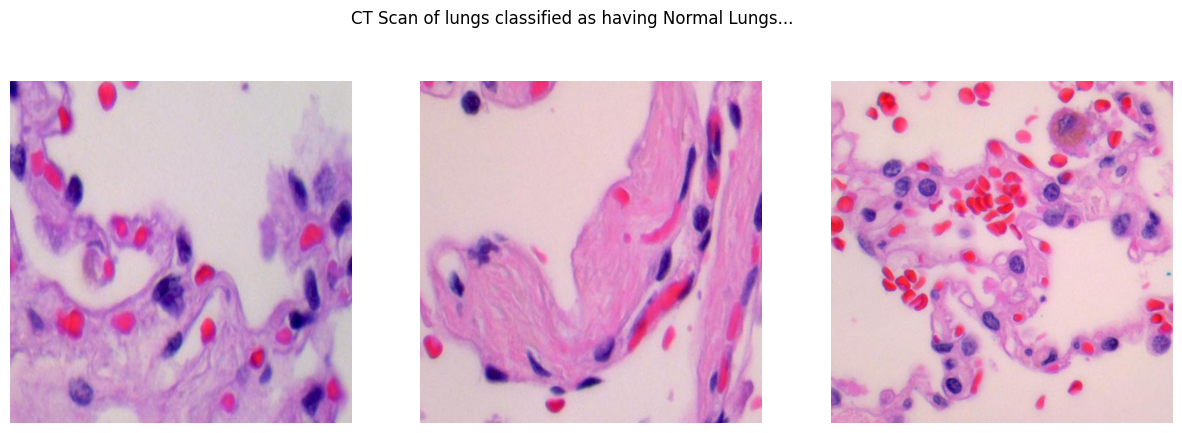

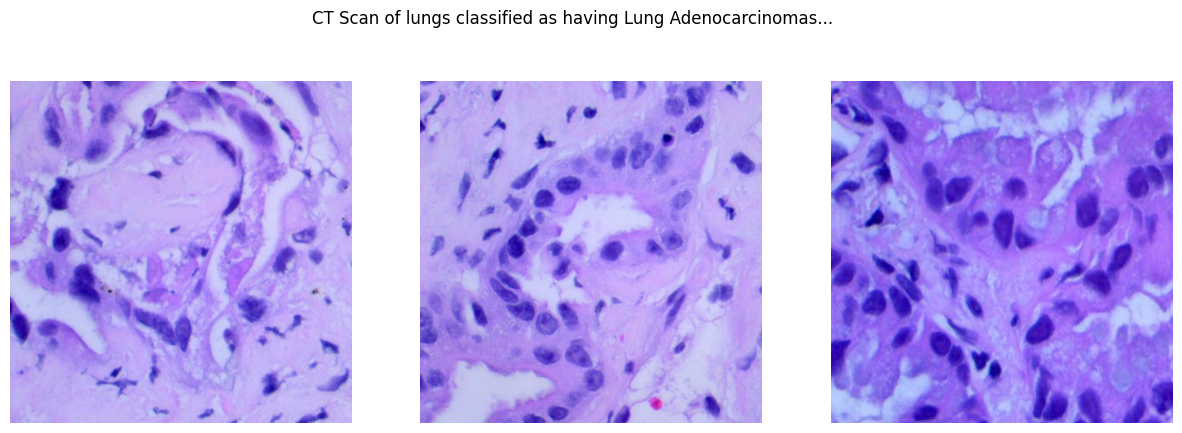

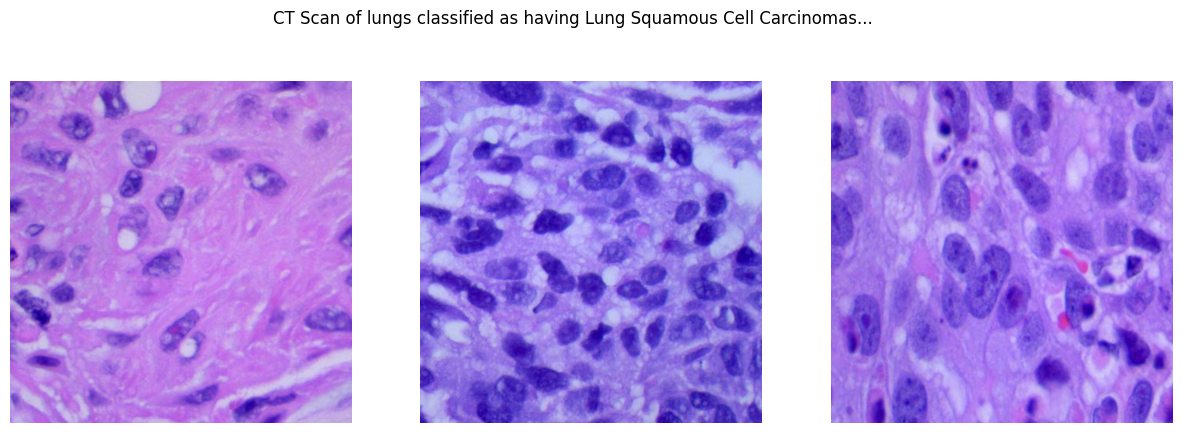

In [10]:
for c, condition in class_map.items():
    images = os.listdir(f"{lung_images}/{c}")

    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle(f"CT Scan of lungs classified as having {condition}...")

    for i in range(3):
        j = np.random.randint(0, len(images))
        img = np.array(Image.open(f"{lung_images}/{c}/{images[j]}"))
        ax[i].imshow(img)
        ax[i].axis("off")
    plt.show()

Above, we have plotted 3 image samples from each class just to get a view of the data for which our models will be working with. The most obvious difference between images samples in between the classes is that cell carcinomas (cells with lung adenocarcinomas and cells with lung squamous cell carcinomas) are stained purple while normal lung cells without carcinomas are stained pink. From rudimentary research, cell carcinomas can be properly detected and stained with a variety of methods including immunohistochemistry, H&E staining, dyes binding to cancer cell nuclei, etc.. 

This may prove to be a crucial feature in predictive analysis; however, cell staining seen in CT scans may not be enough to train a model which can accurately predict whether a CT scan of lung cells contains lung cell carcinomas or not. Let's continue with our EDA and examine what results we get from future predictive analysis.

### Image Dimensions

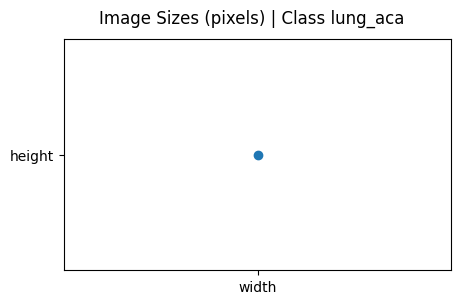

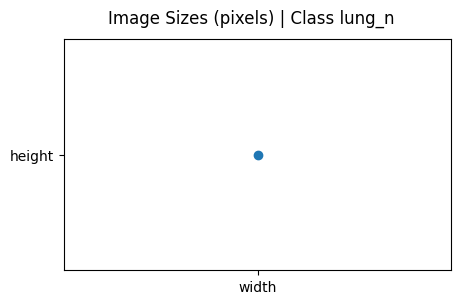

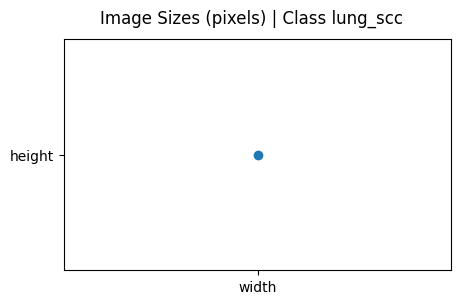

In [11]:
for i, c in enumerate(classes):
    images = glob(f"{lung_images}/{c}/*jpeg")

    fig, ax = plt.subplots(figsize=(5, 3))
    fig.suptitle(f"Image Sizes (pixels) | Class {c}")

    height, width = [], []
    for image in images:
        img = cv2.imread(image)
        h, w, c = img.shape
        height.append(h)
        width.append(w)

    ax.scatter(x="width", y="height")

Here, we see that all images in all classes have image dimensions of 768 pixels (height) x 768 pixels (width). Consistency in image sizes is pertinent when training CNNs for image processing. Our current dataset achieves that; however, let's downsize the images to reduce computation / training time for our image processing models as training a model on 768 x 768 x 3 images can be quite computationally expensive at scale.

### Image Processing / Resizing

In [12]:
IMAGE_SIZE = 128
SPLIT = 0.2
EPOCHS = 10
BATCH_SIZE = 64

In [13]:
X_ml = []
y_ml = []
X_dl = []

for i, c in enumerate(class_map.keys()):
    images = glob(f"{lung_images}/{c}/*jpeg")

    for image in images:
        img = cv2.imread(image)
        img_resized = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))

        X_ml.append(img_resized.flatten())
        y_ml.append(i)
        X_dl.append(img_resized)

In [14]:
X_ml = np.array(X_ml)
y_ml = np.array(y_ml)
X_dl = np.array(X_dl)
y_dl = pd.get_dummies(y_ml).values

In [15]:
X_train_ml, X_test_ml, y_train_ml, y_test_ml = train_test_split(
    X_ml, y_ml, test_size=SPLIT, random_state=50
)
X_train_ml.shape, X_test_ml.shape, y_train_ml.shape, y_test_ml.shape

((12000, 49152), (3000, 49152), (12000,), (3000,))

In [16]:
X_train_dl, X_test_dl, y_train_dl, y_test_dl = train_test_split(
    X_dl, y_dl, test_size=SPLIT, random_state=50
)
X_train_dl.shape, X_test_dl.shape, y_train_dl.shape, y_test_dl.shape

((12000, 128, 128, 3), (3000, 128, 128, 3), (12000, 3), (3000, 3))

Now that we've finised our exploratory data analysis (EDA) and data preparation, we can move onto predictive analysis.

## Classical Machine Learning

In [17]:
def print_classification_metrics(y_true, y_pred, model_type):
    accuracy = accuracy_score(y_true=y_true, y_pred=y_pred)
    precision = precision_score(y_true=y_true, y_pred=y_pred)
    recall = recall_score(y_true=y_true, y_pred=y_pred)
    f1 = f1_score(y_true=y_true, y_pred=y_pred)

    print(f"Test accuracy of {model_type} model: {accuracy:.2f}")
    print(f"Test precision of {model_type} model: {precision:.2f}")
    print(f"Test recall of {model_type} model: {recall:.2f}")
    print(f"Test f1 score of {model_type} model: {f1:.2f}")

### K-Nearest Neighbors

In [ ]:
# K-Nearest Neighbors with N = 5
knn5 = KNeighborsClassifier(n_jobs=-1)
knn5.fit(X_train_ml, y_train_ml)
knn5_pred = knn5.predict(X_test_ml)

KeyboardInterrupt: 

In [ ]:
knn5_pred

array([2, 0, 2, ..., 2, 0, 2])

In [ ]:
cf_knn5 = confusion_matrix(y_test_ml, knn5_pred)
cf_knn5

array([[561, 349, 117],
       [  0,  70, 932],
       [  0,   1, 970]])

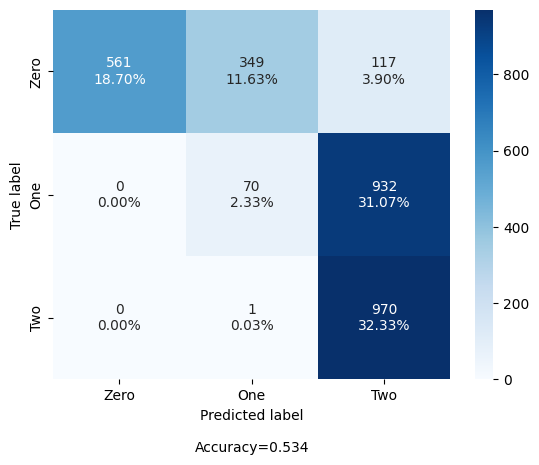

In [ ]:
make_confusion_matrix(cf_knn5, categories=categories, cmap="Blues")

Here, we've trained a K-Nearest Neighbors Classifier with K = 5. a We trained this classifier using a weight function where weights are weighed equally, leaf size of 30, and euclidean distance as the distance measurement. With this model, we achieve a validation accuracy of .

Let's examine how our K-Nearest Neighbors Classifier with K = 5 performs on unseen data.

Here, we see that our K-Nearest Neighbors Classifier with K = 5 achieves a test accuracy of 0.534 on the classification task of determining whether a patient has normal lungs, lung adenocarcinomas, or lung squamous cell carcinomas from images of CT scans of their lungs.

This performance metric isn't the most optimal. Let's try training another K-Nearest Neighbors Classifier with different hyperparameters.

In [ ]:
# K-Nearest Neighbors with N = 3
knn3 = KNeighborsClassifier(n_neighbors=3, n_jobs=-1)
knn3.fit(X_train_ml, y_train_ml)
knn3_pred = knn3.predict(X_test_ml)
knn3_pred

array([2, 0, 2, ..., 2, 0, 2])

In [ ]:
cf_knn3 = confusion_matrix(y_test_ml, knn3_pred)
cf_knn3

array([[624, 305,  98],
       [  0, 182, 820],
       [  0,   1, 970]])

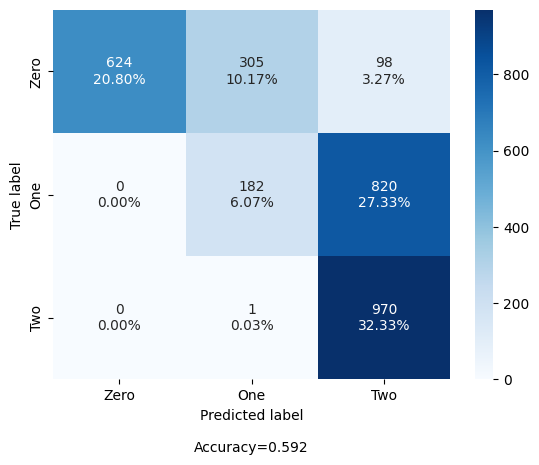

In [ ]:
make_confusion_matrix(cf_knn3, categories=categories, cmap="Blues")

Above we've trained a K-Nearest Neighbors Classifier with K = 3. a We trained this classifier using a weight function where weights are weighed equally, leaf size of 30, and euclidean distance as the distance measurement. With this model, we achieve a validation accuracy of .

Let's examine how our K-Nearest Neighbors Classifier w/ K = 3 performs on unseen data.

Here, we see that our K-Nearest Neighbors Classifier with K = 3 achieves a test accuracy of 0.592 on the classification task of determining whether a patient has normal lungs, lung adenocarcinomas, or lung squamous cell carcinomas from images of CT scans of their lungs.

Our test accuracy improved from our last K-Nearest Neighbors Classifier with K = 5. Let's try training a K-Nearest Neighbors Classifier with K = 4.

In [ ]:
# Load K-Nearest Neighbors with N = 4 model from pkl file
knn4 = joblib.load("models/knn4.pkl")
knn4

KNeighborsClassifier(n_neighbors=4)

In [ ]:
# K-Nearest Neighbors with N = 4
knn4 = KNeighborsClassifier(n_neighbors=4, n_jobs=-1)
knn4.fit(X_train_ml, y_train_ml)


array([2, 0, 2, ..., 2, 0, 2])

In [ ]:
knn4_pred = knn4.predict(X_test_ml)
knn4_pred

array([2, 0, 2, ..., 2, 0, 2])

In [ ]:
cf_knn4 = confusion_matrix(y_test_ml, knn4_pred)
cf_knn4

array([[674, 255,  98],
       [  0, 193, 809],
       [  0,   4, 967]])

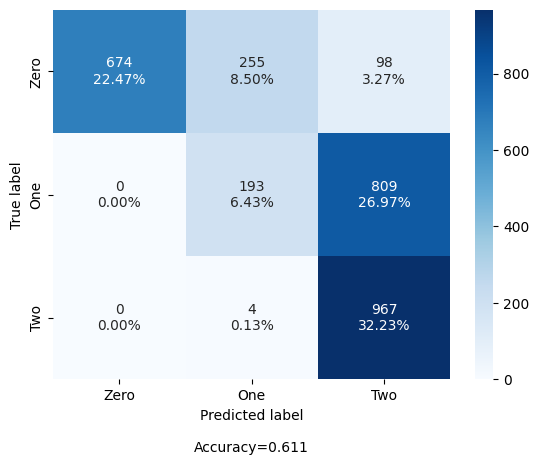

In [ ]:
make_confusion_matrix(cf_knn4, categories=categories, cmap="Blues")

Above we've trained a K-Nearest Neighbors Classifier with N Neighbors = 4. a We trained this classifier using a weight function where weights are weighed equally, leaf size of 30, and euclidean distance as the distance measurement. With this model, we achieve a validation accuracy of .

Let's examine how our Logistic Regression Probabilistic Classifier performs on unseen data.

Here, we see that our K-Nearest Neighbors Classifier with K = 4 achieves a test accuracy of 0.611 on the classification task of determining whether a patient has normal lungs, lung adenocarcinomas, or lung squamous cell carcinomas from images of CT scans of their lungs.

Since our test accuracy improved from our last K-Nearest Neighbors Classifier with K = 3 to K = 4 but drops when training a K-Nearest Neighbors Classifier with K = 3, we see that this is the most optimal the K-Nearest Neighbors Classifier can do on this classification task (without adjusting other hyperparameters).

Let's try seeing how Support Vector Classifiers do on this image classification task.

In [ ]:
# Save the KNN model
# joblib.dump(knn4, "models/knn4.pkl")

### Stochastic Gradient Descent Classifier - Logistic Regression

#### L1 Regularization - Lasso Regression

In [18]:
sgd_clf = SGDClassifier(
    loss='log_loss', 
    penalty='l1',
    n_jobs=-1
)
sgd_clf.fit(X_train_ml, y_train_ml)

SGDClassifier(loss='log_loss', n_jobs=-1, penalty='l1')

In [23]:
sgd_clf_scores = cross_val_score(
    estimator=clone(sgd_clf),
    X=X_train_ml,
    y=y_train_ml,
    cv=3,
    scoring='accuracy',
    n_jobs=-1
)
sgd_clf_scores

array([0.76333333, 0.78291667, 0.78041667, 0.76291667, 0.77416667])

In [24]:
sgd_clf_pred_train = cross_val_predict(
    estimator=clone(sgd_clf),
    X=X_train_ml,
    y=y_train_ml,
    cv=3,
    n_jobs=-1
)
sgd_clf_pred_train

array([1, 2, 2, ..., 1, 2, 1])

In [25]:
cf_sgd_clf_train = confusion_matrix(y_train_ml, sgd_clf_pred_train)
cf_sgd_clf_train

array([[3811,  101,   61],
       [ 124, 2447, 1427],
       [   6, 1139, 2884]])

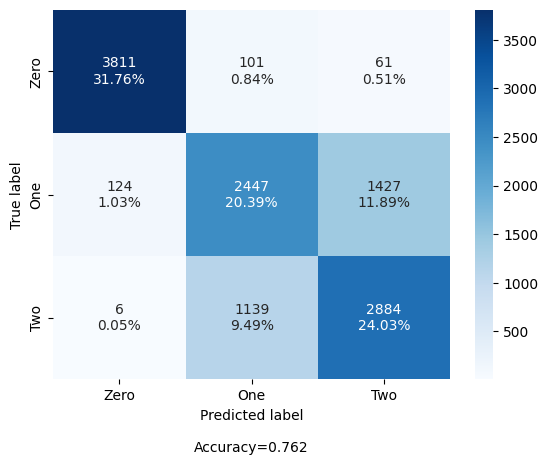

In [26]:
categories = ["Zero", "One", "Two"]
make_confusion_matrix(cf_sgd_clf_train, categories=categories, cmap="Blues")

Above we've trained a Stochastic Gradient Descent Classifier with a loss function similar to that of a logistic regression model, essentially making this a Logistic Regression Probabilistic Classifier, on our lung cancer image dataset. We trained our classifier using L1 regularization (Lasso Regression), a regularization term of 0.0001, l1 ratio of 0.15, and epsilon of 0.1. With this model, we achieve a validation accuracy of 0.762.

Let's examine how our Logistic Regression Probabilistic Classifier w/ L1 regularization performs on unseen CT scans of patients' lungs.

In [31]:
sgd_clf_pred_test = sgd_clf.predict(X_test_ml)

In [35]:
cf_sgd_clf_test = confusion_matrix(y_test_ml, sgd_clf_pred_test)
cf_sgd_clf_test

array([[991,  23,  13],
       [ 45, 603, 354],
       [  1, 268, 702]])

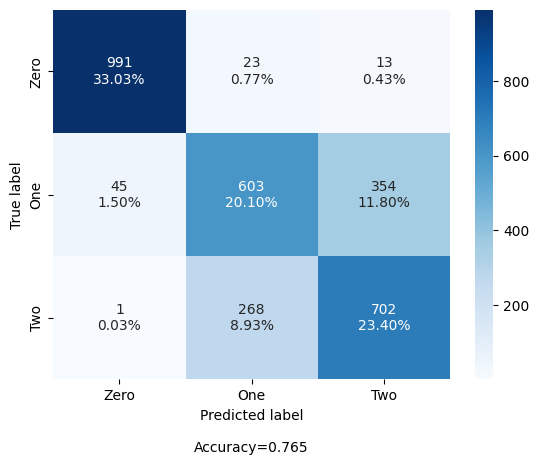

In [36]:
make_confusion_matrix(cf_sgd_clf_test, categories=categories, cmap="Blues")

Here, we see that our Probabilistic Logistic Regression Classifier w/ L1 regularization achieves a test accuracy of 0.765 compared to our best K-Nearest Neighbors Classifier which achieved a test accuracy of 0.611 for this classification task. 

From the get go, it seems training Stochastic Gradient Descent Classifiers (Logistic Regression) on the training image dataset performs better for the classification task of determining whether a patient has normal lungs, lung adenocarcinomas, or lung squamous cell carcinomas from images of CT scans of their lungs than K-Nearest Neighbors Classifiers.

Let's train a few more Stochastic Gradient Descent Classifiers with different hyperparameters to come to a more well-rounded conclusion.

In [30]:
# Save the SGD Classifier model
# joblib.dump(sgd_clf, "models/sgd/sgd_l1.pkl")

['models/sgd/sgd_l1.pkl']

#### L2 Regularization - Ridge Regression

In [27]:
sgd_clf_l2 = SGDClassifier(
    loss='log_loss', 
    penalty='l2',
    n_jobs=-1
)
sgd_clf_l2.fit(X_train_ml, y_train_ml)

SGDClassifier(loss='log_loss', n_jobs=-1)

In [37]:
sgd_clf_l2_pred_train = cross_val_predict(
    estimator=clone(sgd_clf_l2),
    X=X_train_ml,
    y=y_train_ml,
    cv=3,
    n_jobs=-1
)
sgd_clf_l2_pred_train

array([2, 2, 2, ..., 1, 1, 1])

In [38]:
cf_sgd_clf_l2_pred_train = confusion_matrix(y_train_ml, sgd_clf_l2_pred_train)
cf_sgd_clf_l2_pred_train

array([[3830,   95,   48],
       [  93, 2035, 1870],
       [   4,  711, 3314]])

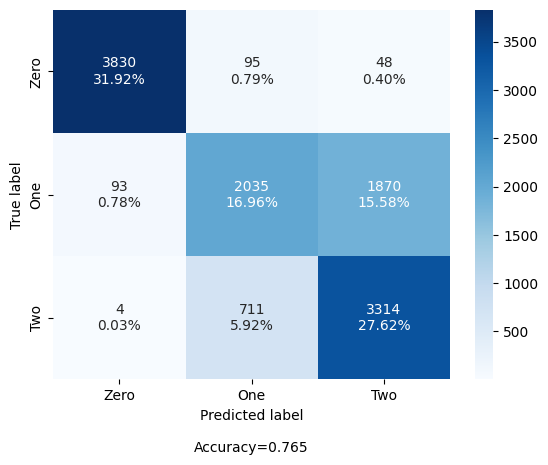

In [39]:
make_confusion_matrix(cf_sgd_clf_l2_pred_train, categories=categories, cmap="Blues")

Above we've trained another Logistic Regression Probabilistic Classifier on our lung cancer image dataset. This time, we trained our classifier using L2 regularization (Ridge Regression), a regularization term of 0.0001, l1 ratio of 0.15, and epsilon of 0.1. With this model, we achieve a validation accuracy of 0.765.

Let's examine how our Logistic Regression Probabilistic Classifier w/ L2 regularization performs on unseen data.

In [40]:
sgd_clf_l2_pred_test = sgd_clf_l2.predict(X_test_ml)

In [42]:
cf_sgd_clf_l2_pred_test = confusion_matrix(y_test_ml, sgd_clf_l2_pred_test)
cf_sgd_clf_l2_pred_test

array([[982,  33,  12],
       [ 17, 642, 343],
       [  0, 234, 737]])

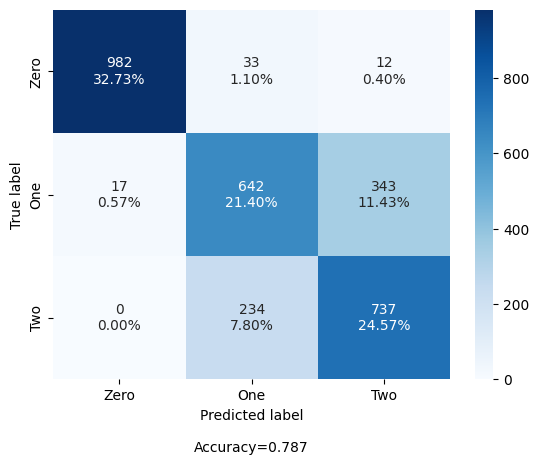

In [43]:
make_confusion_matrix(cf_sgd_clf_l2_pred_test, categories=categories, cmap="Blues")

Here, we see that our Probabilistic Logistic Regression Classifier w/ L2 regularization achieves a test accuracy of 0.787 on the classification task of determining whether a patient has normal lungs, lung adenocarcinomas, or lung squamous cell carcinomas from images of CT scans of their lungs.

#### Elastic Net Regularization

In [44]:
sgd_clf_elasticnet = SGDClassifier(
    loss='log_loss', 
    penalty='elasticnet',
    n_jobs=-1
)
sgd_clf_elasticnet.fit(X_train_ml, y_train_ml)

In [ ]:
sgd_clf_elasticnet_pred_train = cross_val_predict(
    estimator=clone(sgd_clf_elasticnet),
    X=X_train_ml,
    y=y_train_ml,
    cv=3,
    n_jobs=-1
)
sgd_clf_elasticnet_pred_train

In [ ]:
cf_sgd_clf_elasticnet_pred_train = confusion_matrix(y_train_ml, sgd_clf_elasticnet_pred_train)
cf_sgd_clf_elasticnet_pred_train

In [ ]:
make_confusion_matrix(cf_sgd_clf_elasticnet_pred_train, categories=categories, cmap="Blues")

We've trained a last Logistic Regression Probabilistic Classifier on our lung cancer image dataset. This classifier was trained using Elastic net regularization, a regularization term of 0.0001, l1 ratio of 0.15, and epsilon of 0.1. With this model, we achieve a validation accuracy of ___.

Let's examine how our Logistic Regression Probabilistic Classifier w/ Elastic net regularization performs on unseen data.

In [ ]:
sgd_clf_elasticnet_pred_test = sgd_clf_elasticnet.predict(X_test_ml)

In [ ]:
cf_sgd_clf_elasticnet_pred_test = confusion_matrix(y_test_ml, sgd_clf_elasticnet_pred_test)
cf_sgd_clf_elasticnet_pred_test

In [ ]:
make_confusion_matrix(cf_sgd_clf_elasticnet_pred_test, categories=categories, cmap="Blues")

Here, we see that our Probabilistic Logistic Regression Classifier w/ Elastic net regularization achieves a test accuracy of ___ on the classification task of determining whether a patient has normal lungs, lung adenocarcinomas, or lung squamous cell carcinomas from images of CT scans of their lungs.

### Support Vector Machine

#### Linear Kernel SVC

In [ ]:
linear_kernel_svc = Pipeline(
    [("Scaler", StandardScaler()), ("svm_clf", SVC(kernel="linear", C=5))]
)

In [ ]:
# Load Polynomial Kernel SVC model from pkl file
# polynomial_kernel_svc = joblib.load("models/linear_kernel_svc.pkl")
# polynomial_kernel_svc

In [ ]:
linear_kernel_svc.fit(X_train_ml, y_train_ml)

Pipeline(steps=[('Scaler', StandardScaler()),
                ('svm_clf', SVC(C=5, kernel='linear'))])

In [ ]:
linear_kernel_svc_pred = linear_kernel_svc.predict(X_test_ml)
linear_kernel_svc_pred

array([1, 0, 0, ..., 2, 0, 1])

In [ ]:
cf_linear_kernel_svc = confusion_matrix(y_test_ml, linear_kernel_svc_pred)
cf_linear_kernel_svc

array([[1001,   23,    3],
       [  28,  619,  355],
       [   2,  241,  728]])

In [ ]:
make_confusion_matrixcf_linear_kernel_svc, categories=categories, cmap="Blues")

Here, we've trained a Support Vector Classifier with a linear kernel. a We trained this classifier using a C regularization parameter of 1.0, shrinking heuristic, and one-vs-rest decision function. With this model, we achieve a validation accuracy of .

Let's examine how our Support Vector Classifier with a linear kernel performs on unseen data.

Here, we see that our Support Vector Classifier with a linear kernel achieves a test accuracy of 0.783 on the classification task of determining whether a patient has normal lungs, lung adenocarcinomas, or lung squamous cell carcinomas from images of CT scans of their lungs.

This is a significant improvement from all of our K-Nearest Neighbor Classifiers and our SGD (Logistic Regression) Classifiers. Let's try to see if we can perform better by training Support Vector Classifiers with non-linear kernels as non-linear kernels may fit image data better than linear kernels.

In [ ]:
# Save the Linear Kernel SVC model
joblib.dump(linear_kernel_svc, "models/linear_kernel_svc.pkl")

['models/linear_kernel_svc.pkl']

#### Polynomial Kernel SVC

In [ ]:
polynomial_kernel_svc = Pipeline(
    [
        ("Scaler", StandardScaler()),
        ("svm_clf", SVC(kernel="poly", degree=3, coef0=1, C=5)),
    ]
)

In [ ]:
# Load Polynomial Kernel SVC model from pkl file
# polynomial_kernel_svc = joblib.load("models/polynomial_kernel_svc.pkl")
# polynomial_kernel_svc

In [ ]:
polynomial_kernel_svc.fit(X_train_ml, y_train_ml)

Pipeline(steps=[('Scaler', StandardScaler()),
                ('svm_clf', SVC(C=5, coef0=1, kernel='poly'))])

In [ ]:
polynomial_kernel_svc_pred = polynomial_kernel_svc.predict(X_test_ml)
polynomial_kernel_svc_pred

array([1, 0, 0, ..., 2, 0, 2])

In [ ]:
cf_polynomial_kernel_svc = confusion_matrix(y_test_ml, polynomial_kernel_svc_pred)
cf_polynomial_kernel_svc

array([[1009,   16,    2],
       [   4,  787,  211],
       [   0,   47,  924]])

In [28]:
make_confusion_matrix(cf_polynomial_kernel_svc, categories=categories, cmap="Blues")

NameError: name 'cf_polynomial_kernel_svc' is not defined

Here, we've trained a Support Vector Classifier with a polynomial kernel. a We trained this classifier using a C regularization parameter of 5, polynomial kernel degree of 3, coef0 of 1, kernel coefficient gamma of 'scale', shrinking heuristic, and one-vs-rest decision function. With this model, we achieve a validation accuracy of .

Let's examine how our Support Vector Classifier with a polynomial kernel performs on unseen data.

Here, we see that our Support Vector Classifier with a polynomial kernel achieves a test accuracy of 0.907 on the classification task of determining whether a patient has normal lungs, lung adenocarcinomas, or lung squamous cell carcinomas from images of CT scans of their lungs.

Again, we see a significant performance from our previous (and fairly performant) Support Vector Classifier trained with a linear kernel. 

In [ ]:
# Save the Polynomial Kernel SVC model
joblib.dump(polynomial_kernel_svc, "models/polynomial_kernel_svc.pkl")

['models/polynomial_kernel_svc.pkl']

#### Guassian RBF Kernel SVC

In [ ]:
rbf_kernel_svm_clf = Pipeline(
    [("scaler", StandardScaler()), ("svm_clf", SVC(kernel="rbf", gamma=5, C=0.001))]
)

In [ ]:
rbf_kernel_svm_clf.fit(X_train_ml, y_train_ml)

Pipeline(steps=[('scaler', StandardScaler()),
                ('svm_clf', SVC(C=0.001, gamma=5))])

In [ ]:
rbf_kernel_svc_pred = rbf_kernel_svm_clf.predict(X_test_ml)
rbf_kernel_svc_pred

array([2, 2, 2, ..., 2, 2, 2])

In [ ]:
cf_rbf_kernel_svc = confusion_matrix(y_test_ml, rbf_kernel_svc_pred)
cf_rbf_kernel_svc

array([[   0,    0, 1027],
       [   0,    0, 1002],
       [   0,    0,  971]])

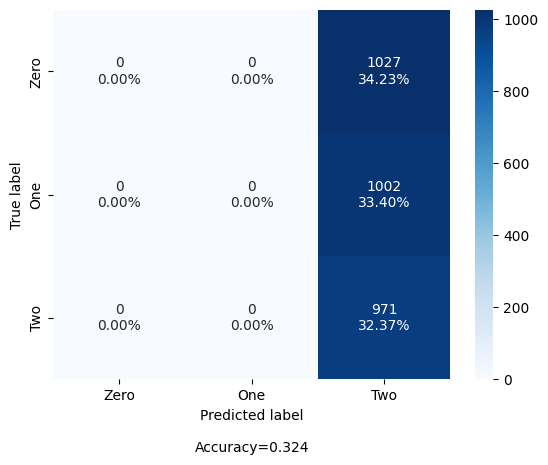

In [ ]:
make_confusion_matrix(cf_rbf_kernel_svc, categories=categories, cmap="Blues")

Here, we've trained a Support Vector Classifier with a Guassian Radial Bias Function kernel. a We trained this classifier using a C regularization parameter of 0.001, kernel coefficient gamma of 5, shrinking heuristic, and one-vs-rest decision function. With this model, we achieve a validation accuracy of .

Let's examine how our Support Vector Classifier with a polynomial kernel performs on unseen data.

Here, we see that our Support Vector Classifier with a Guassian RBF kernel achieves a test accuracy of 0.324. Our Support Vector Classifier with a Guassian RBF kernel yielded a significant decrease in performance in comparison to our previous Support Vector Classifier with polynomial kernel. Interestingly enough, from an examination of our confusion matrix above, it seems our Support Vector Classifier with a Guassian RBF kernel classified all of the test examples as lungs with lung squamous cell carcinomas. Perhaps some further scrutiny must be done to determine whether the Guassian RBF kernel is sensitive to imbalances in data / overfits significantly to subsets of the dataset.

Overall, out of all the classical machine learning models we've trained from Scikit-Learn's library, we find that fitting a Support Vector Machine Classifier with a polynomial kernel, C regularization parameter of 5, polynomial kernel degree of 3, coef0 of 1, kernel coefficient gamma of 'scale', shrinking heuristic, and one-vs-rest decision function can classify, from images of CT scans of patient lungs, whether a patient has normal lungs, lung adenocarcinomas, or lung squamous cell carcinomas with a relatively high accuracy of 0.907.

## Deep Learning

### Basic Sequential CNN Architecture

In [16]:
sequential_cnn = keras.models.Sequential([
    layers.Conv2D(filters=32,
                  kernel_size=(5, 5),
                  activation='relu',
                  input_shape=(IMAGE_SIZE,
                               IMAGE_SIZE,
                               3),
                  padding='same'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(filters=64,
                  kernel_size=(3, 3),
                  activation='relu',
                  padding='same'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(filters=128,
                  kernel_size=(3, 3),
                  activation='relu',
                  padding='same'),
    layers.MaxPooling2D(2, 2),

    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(3, activation='softmax')
])

In [17]:
# Summary of Sequential CNN architecture
sequential_cnn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     8,388,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,518,467 (32.50 MB)

 Trainable params: 8,517,699 (32.49 MB)

 Non-trainable params: 768 (3.00 KB)

In [18]:
keras.utils.plot_model(
	sequential_cnn,
	show_shapes = True,
	show_dtype = True,
	show_layer_activations = True
)

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


### AlexNet Architecture

### VGGNet

### Resnet

### Dense Net

### Efficient Net